In [311]:
import h5py
import matplotlib.pyplot as plt
import os
import importlib
import pid_functions
import numpy as np
from scipy import signal
from scipy.io import savemat
importlib.reload(pid_functions)
import seaborn as sns
sns.set_context('paper')

In [309]:
def peak_plotter(PID_trace,odor_trace):
    for i in range(len(PID_trace)):
        peaks, _ = signal.find_peaks(odor_trace[i,:], distance=50)
        for p in range(len(peaks)):
            plt.plot(PID_trace[i,peaks[p]-250:peaks[p]+250])
            plt.plot(odor_trace[i,peaks[p]-250:peaks[p]+250]/100) #The /500 is arbitrary just to have it in the same scale as the PID
            plt.title('Trial '+str(i)+', Peak'+str(p))
            plt.show()


def average_peak_triggered(odor_data, pid_data, fs=1000, pre_ms=200, post_ms=200, min_interval_ms=400, height=[10,95], prominence=None):
    """
    Extracts windows around peaks and averages them.
    
    Parameters
    ----------
    signal_data : 1D array
        The signal to process.
    fs : int
        Sampling frequency in Hz.
    pre_ms : int
        Time before peak (ms).
    post_ms : int
        Time after peak (ms).
    min_interval_ms : int
        Minimum separation between peaks (ms).
    height : float or None
        Minimum height for peak detection (passed to scipy.signal.find_peaks).
    prominence : float or None
        Minimum prominence for peak detection.
    
    Returns
    -------
    avg_waveform : 1D array
        Average waveform around selected peaks.
    all_waveforms : 2D array
        Individual extracted waveforms (n_peaks x window_length).
    peak_indices : list
        Indices of the selected peaks.
    """
    pre_samples = int(pre_ms * fs / 1000)
    post_samples = int(post_ms * fs / 1000)
    min_interval_samples = int(min_interval_ms * fs / 1000)

    # detect peaks
    peaks, _ = signal.find_peaks(odor_data, height=height, prominence=prominence, distance=min_interval_samples)

    # collect waveforms
    waveforms = []
    for p in peaks:
        if p - pre_samples >= 0 and p + post_samples < len(odor_data):
            snippet = pid_data[p - pre_samples : p + post_samples]
            waveforms.append(snippet)

    waveforms = np.array(waveforms)
    avg_waveform = np.mean(waveforms, axis=0) if waveforms.size > 0 else None

    return avg_waveform, waveforms, peaks

/Users/boero/OEA_Data_Analysis/PID/20250828/mb_5perc_94o_pmed_g5_0.h5
block_training


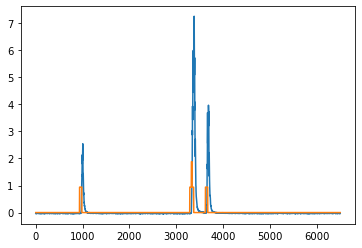

In [268]:
path = os.getcwd() + '/PID/20250828/'
filename = 'mb_5perc_94o_pmed_g5_0.h5'
filepath = path + filename
print(filepath)
dfile = h5py.File(filepath,'r')
print(list(dfile['measurement'].keys())[0]) #['measurement'].keys()
data = dfile['measurement/block_training/buffer'][:] #load data buffer to numpy arrray
stat = dfile['measurement/block_training/stat'][:] #load task statistics
side_stat = dfile['measurement/block_training/side_stat'][:]  #load task statistics with side information
settings = dfile['measurement/block_training/settings'].attrs

# Load raw data into numpy array
lick0 = 1
lick1 = 2
PID_index = 3 # index number for PID signal
cl_air = 6 + 4 #index number of clean air channel in h5file
odor_1 = 6 + 0 #index number of odor channel 1 in h5file
end_time = len(data) # in milisecond
delay_time = settings['delay'] #ms, delay time of the task
go_time = settings['go'] #ms, go time of the task
refract_time = settings['refract'] #ms, refraction period time of the task
pulse_time = 50
ntrials = np.argwhere(np.diff(data[:,cl_air]) == -94).shape[0]

PID_signal = data[0:end_time,PID_index]
filt_signal = pid_functions.bp_bessel(PID_signal-np.median(PID_signal))
odor_profile_1 = data[0:end_time,odor_1]

total_time = delay_time + go_time #ms, the total time that we are analyzing for each trial
onset = np.argwhere(np.diff(data[:,cl_air]) == -94).reshape(ntrials,1) #find out hte onset of each trial
interval = np.arange(total_time).reshape(1,total_time) #define a interval to extract for each trial
refract_interval = np.arange(refract_time)[::-1].reshape(1,refract_time) # define a interval for pretrial, flipped
trial_inds = onset + interval #get the indices for all the wanted data for all trials
pre_inds = onset - refract_interval #get the indices for all the wanted data in all pre-trials

# get all the trial informations
trial_odor = data[:,odor_1][trial_inds[:-1,:]]
PID = PID_signal[trial_inds[:-1,:]]
PID_filt = filt_signal[trial_inds[:-1,:]]

plt.plot(PID[11,:])
plt.plot(trial_odor[11,:]/100) #The /500 is arbitrary just to have it in the same scale as the PID
#plt.savefig('new_PID_trace.svg', format='svg', transparent='True')

In [ ]:
peak_plotter(PID, trial_odor)

In [ ]:
lowtrials = [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34]
from itertools import chain
import seaborn as sns

snips =  list()
to_low = trial_odor[lowtrials,:]
pid_low = PID[lowtrials,:]
for i in range(to_low.shape[0]):
    _, all_snippets, _ = average_peak_triggered(to_low[i,:], pid_low[i,:], fs=1000, pre_ms=200, post_ms=200, min_interval_ms=600, height=[10,95], prominence=1)
    snips.append(all_snippets)

cleaned = [x for x in snips if len(x) > 0]
flattened = list(chain.from_iterable(cleaned))
f_array = np.array(flattened)

mean_peak_mb = f_array.mean(0)
random_array = np.random.rand(20)
arr_extended = np.concatenate([random_array, mean_peak_mb])

(150.0, 450.0)

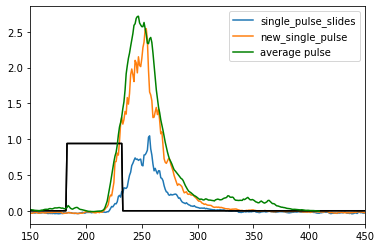

In [306]:
plt.plot(PID[2,1115:1615], label='single_pulse_slides')
plt.plot(PID[11,750:1250], label='new_single_pulse')

plt.plot(trial_odor[2,1115:1615]/100, color='k')
plt.plot(trial_odor[11,750:1250]/100, color='k')
plt.plot(arr_extended[10:510], color='green', label='average pulse')
plt.legend()

plt.xlim(150,450)

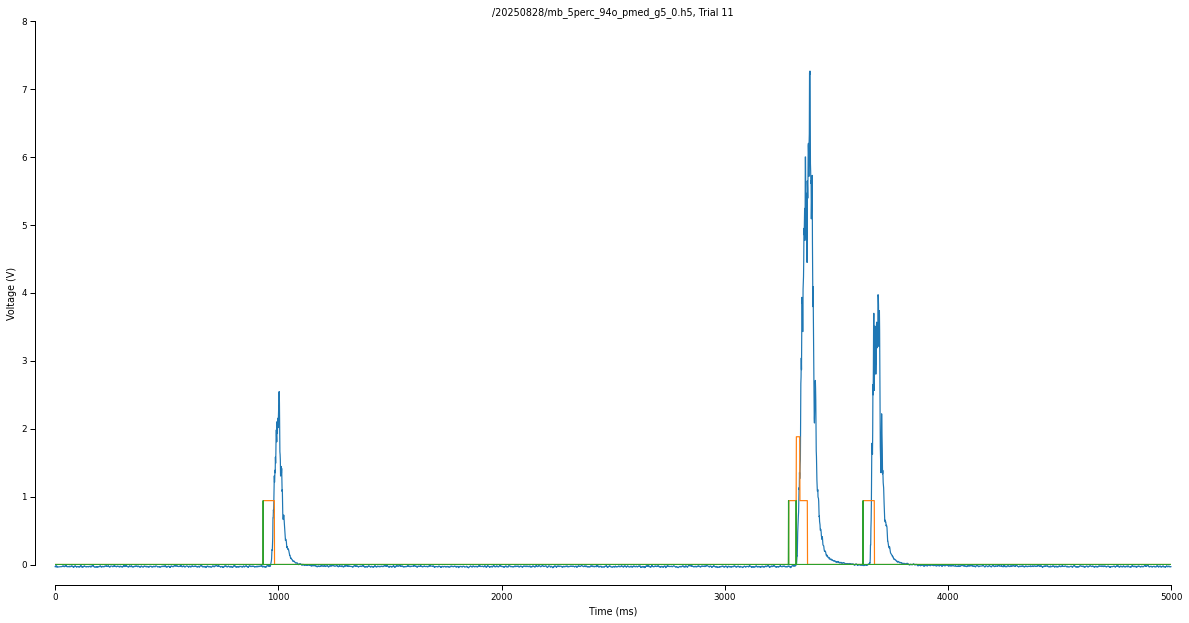

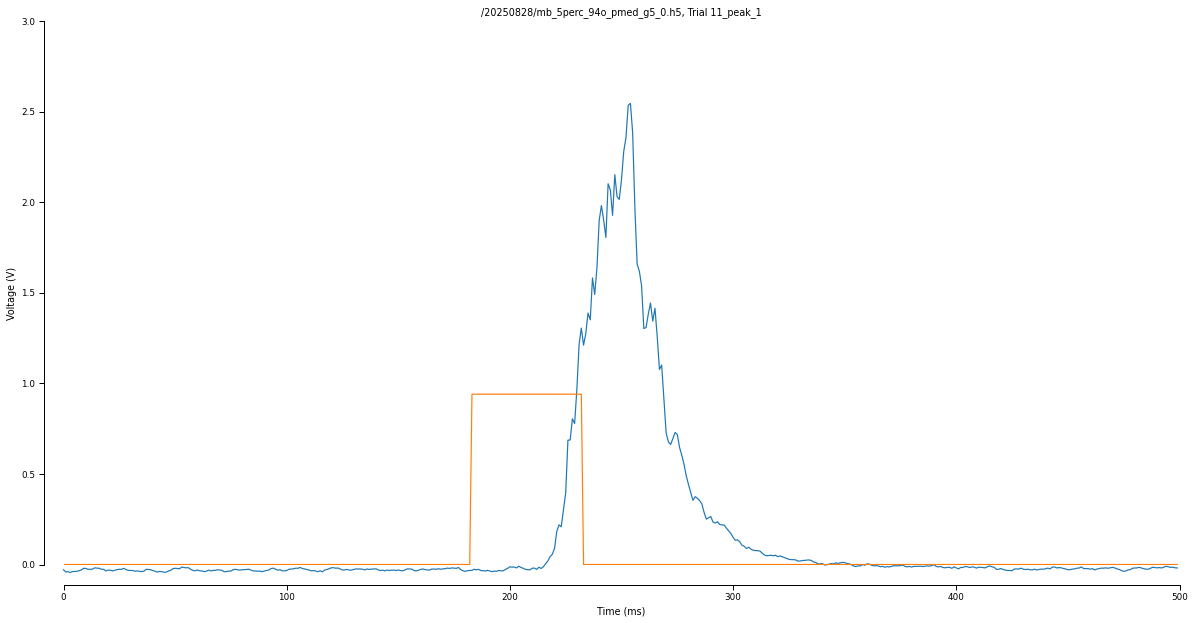

In [323]:
trial=11

plt.figure(figsize=(20,10))

plt.plot(PID[trial,:5000], clip_on=False)
plt.plot(trial_odor[trial,:5000]/100)
plt.plot(np.diff(trial_odor[trial, :5000])/100)
plt.xlim(0,5000)
plt.ylim(0,8)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('/20250828/mb_5perc_94o_pmed_g5_0.h5, Trial '+str(trial))
sns.despine(offset=20)

plt.savefig('PID_methyl_butyrate_5perc_low_trial.svg', format='svg', bbox_inches='tight', transparent='true')
plt.savefig('PID_methyl_butyrate_5perc_low_trial.png', format='png', bbox_inches='tight', transparent='true')
plt.savefig('PID_methyl_butyrate_5perc_low_trial.pdf', format='pdf', bbox_inches='tight', transparent='true')

plt.figure(figsize=(20,10))

plt.plot(PID[trial,750:1250], clip_on=False)
plt.plot(trial_odor[trial,750:1250]/100)
plt.xlim(0,500)
plt.ylim(0,3)
plt.title('/20250828/mb_5perc_94o_pmed_g5_0.h5, Trial '+str(trial)+'_peak_1')


plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
sns.despine(offset=20)

plt.savefig('PID_methyl_butyrate_5perc_single_pulse.svg', format='svg', bbox_inches='tight', transparent='true')
plt.savefig('PID_methyl_butyrate_5perc_single_pulse.png', format='png', bbox_inches='tight', transparent='true')
plt.savefig('PID_methyl_butyrate_5perc_single_pulse.pdf', format='pdf', bbox_inches='tight', transparent='true')

# plt.figure(figsize=(20,10))
# plt.plot(PID_filt[trial,1200:1700])
# plt.plot(trial_odor[trial,1200:1700]/100)

plt.show() #The /500 is arbitrary just to have it in the same scale as the PID

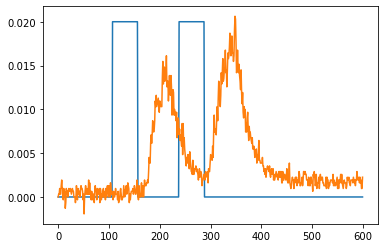

In [6]:
# Input parameter
dfile = h5py.File('./PID/20230410/V1_0.h5','r')
data = dfile['measurement/block_training/buffer'][:] #load data buffer to numpy arrray
stat = dfile['measurement/block_training/stat'][:] #load task statistics
side_stat = dfile['measurement/block_training/side_stat'][:]  #load task statistics with side information
settings = dfile['measurement/block_training/settings'].attrs

# Load raw data into numpy array
breath = 0
lick0 = 1
lick1 = 2
PID = 3 # index number for PID signal
cl_air = 6 + 4 #index number of clean air channel in h5file
odor_1 = 6 + 1 # 6 + number of the channel that is being used for odor delivery
end_time = len(data) # in milisecond

#Assigning identity to the different channels 
odor_profile_1 = data[0:end_time,odor_1].astype(int)
cl_air_profile = np.diff(data[0:end_time,cl_air], 1)
PID_signal = data[0:end_time,PID]

#Defining trial intervals and total number of trials
trial_time = 9
trial_seq = 0
end_trial = np.count_nonzero(cl_air_profile == 94) #You can use the stat to get this but is more troublesome
trial_init = stat[trial_time, 0:(end_trial)]
r_time = (np.rint(trial_init).astype(int))[1:end_trial]
trial_number = stat[trial_seq, 0:(end_trial)].astype(int)

#Correcting the baseline of the signal
PID_corr = PID_signal-median(PID_signal)

#Normalizing the signal to the highest peak.
max_PID=max(PID_signal)
PID_rel = ((PID_signal/max_PID)*100)

plt.plot(odor_profile_1[65000:65600]/5000)
plt.plot(PID_corr[65000:65600])

/Users/boero/OEA_Data_Analysis/PID/20250828/mb_5perc_94o_pmed_g5_only_high_0.h5
block_training


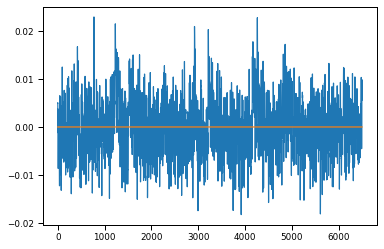

In [325]:
path = os.getcwd() + '/PID/20250828/'
filename = 'mb_5perc_94o_pmed_g5_only_high_0.h5'
filepath = path + filename
print(filepath)
dfile = h5py.File(filepath,'r')
print(list(dfile['measurement'].keys())[0]) #['measurement'].keys()
data = dfile['measurement/block_training/buffer'][:] #load data buffer to numpy arrray
stat = dfile['measurement/block_training/stat'][:] #load task statistics
side_stat = dfile['measurement/block_training/side_stat'][:]  #load task statistics with side information
settings = dfile['measurement/block_training/settings'].attrs

# Load raw data into numpy array
lick0 = 1
lick1 = 2
PID_index = 3 # index number for PID signal
cl_air = 6 + 4 #index number of clean air channel in h5file
odor_1 = 6 + 0 #index number of odor channel 1 in h5file
end_time = len(data) # in milisecond
delay_time = settings['delay'] #ms, delay time of the task
go_time = settings['go'] #ms, go time of the task
refract_time = settings['refract'] #ms, refraction period time of the task
pulse_time = 50
ntrials = np.argwhere(np.diff(data[:,cl_air]) == -94).shape[0]

PID_signal = data[0:end_time,PID_index]
filt_signal = pid_functions.bp_filter(PID_signal-np.median(PID_signal))
odor_profile_1 = data[0:end_time,odor_1]

total_time = delay_time + go_time #ms, the total time that we are analyzing for each trial
onset = np.argwhere(np.diff(data[:,cl_air]) == -94).reshape(ntrials,1) #find out hte onset of each trial
interval = np.arange(total_time).reshape(1,total_time) #define a interval to extract for each trial
refract_interval = np.arange(refract_time)[::-1].reshape(1,refract_time) # define a interval for pretrial, flipped
trial_inds = onset + interval #get the indices for all the wanted data for all trials
pre_inds = onset - refract_interval #get the indices for all the wanted data in all pre-trials

# get all the trial informations
trial_odor = data[:,odor_1][trial_inds[:-1,:]]
PID = PID_signal[trial_inds[:-1,:]]
PID_filt = filt_signal[trial_inds[:-1,:]]

plt.plot(PID_filt[1,:])
plt.plot(trial_odor[1,:]/100) #The /500 is arbitrary just to have it in the same scale as the PID
#plt.savefig('new_PID_trace.svg', format='svg', transparent='True')

0 17.0


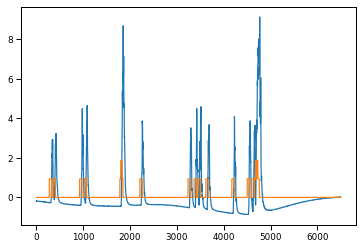

1 0.0


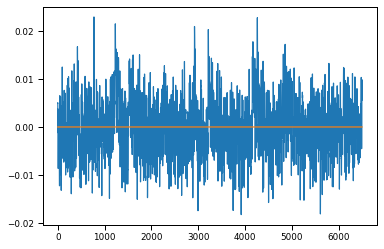

2 13.0


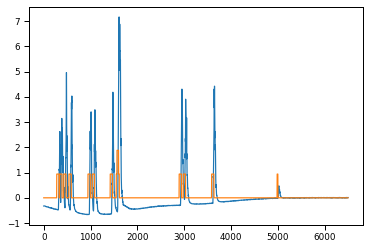

3 12.0


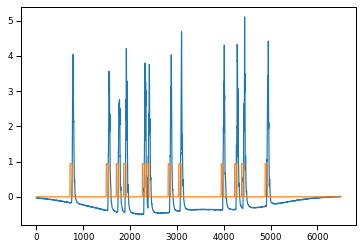

4 12.0


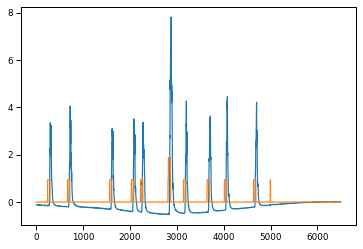

5 17.0


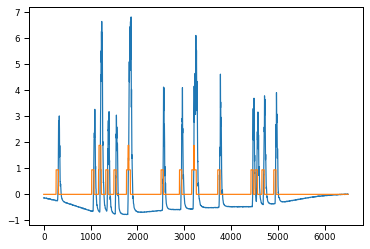

6 17.0


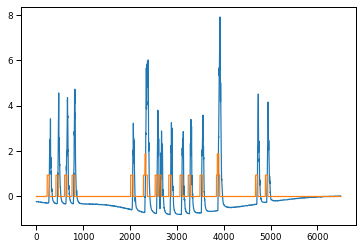

7 0.0


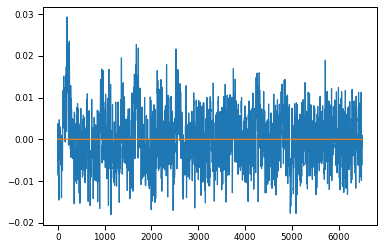

8 10.0


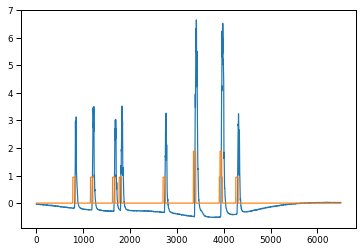

9 23.0


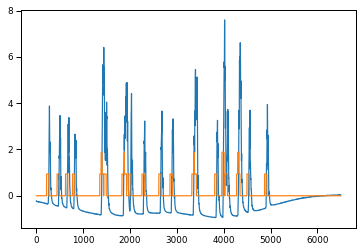

10 11.0


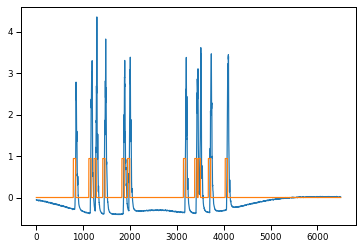

11 9.0


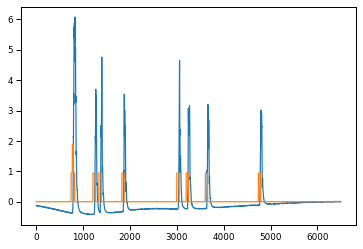

12 18.0


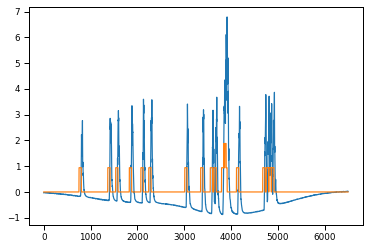

13 12.0


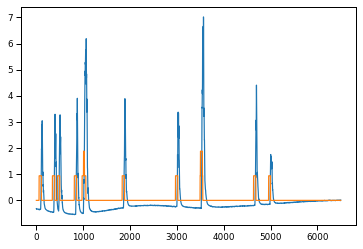

14 13.0


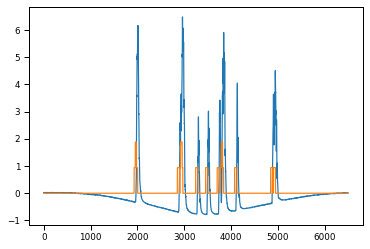

15 10.0


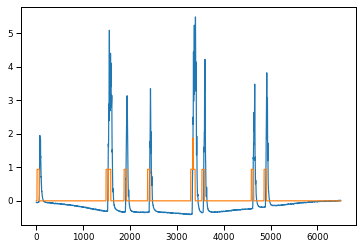

16 15.0


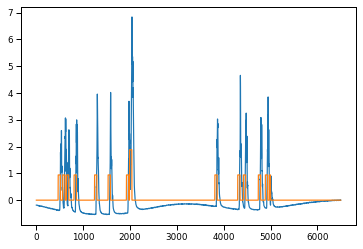

17 10.0


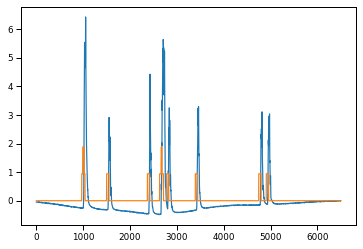

18 12.0


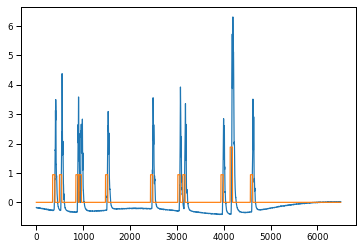

19 13.0


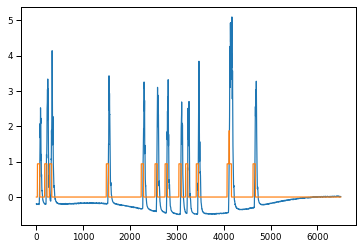

20 0.0


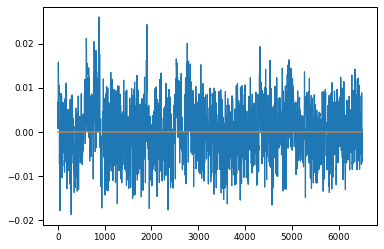

21 15.0


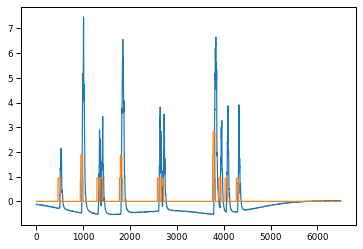

22 13.0


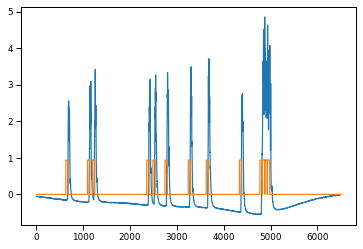

23 12.0


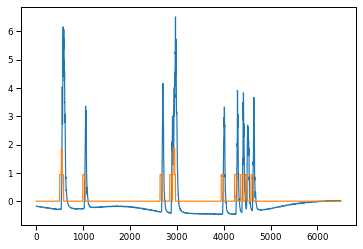

24 12.0


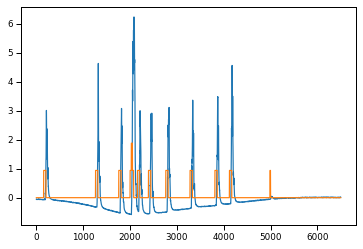

25 15.0


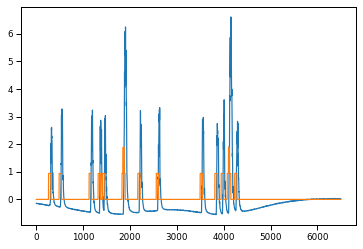

26 12.0


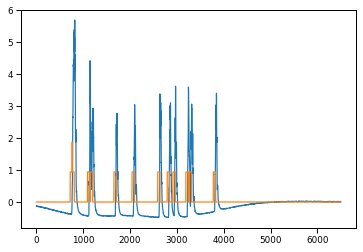

27 16.0


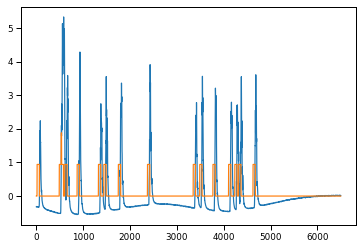

In [327]:
for i in range(len(trial_inds[:-1])):
    print(i, np.ceil(trial_odor[i,:].sum()/(50*94)))
    plt.plot(PID_filt[i,:])
    plt.plot(trial_odor[i,:]/100)
    plt.show() #The /500 is arbitrary just to have it in the same scale as the PID

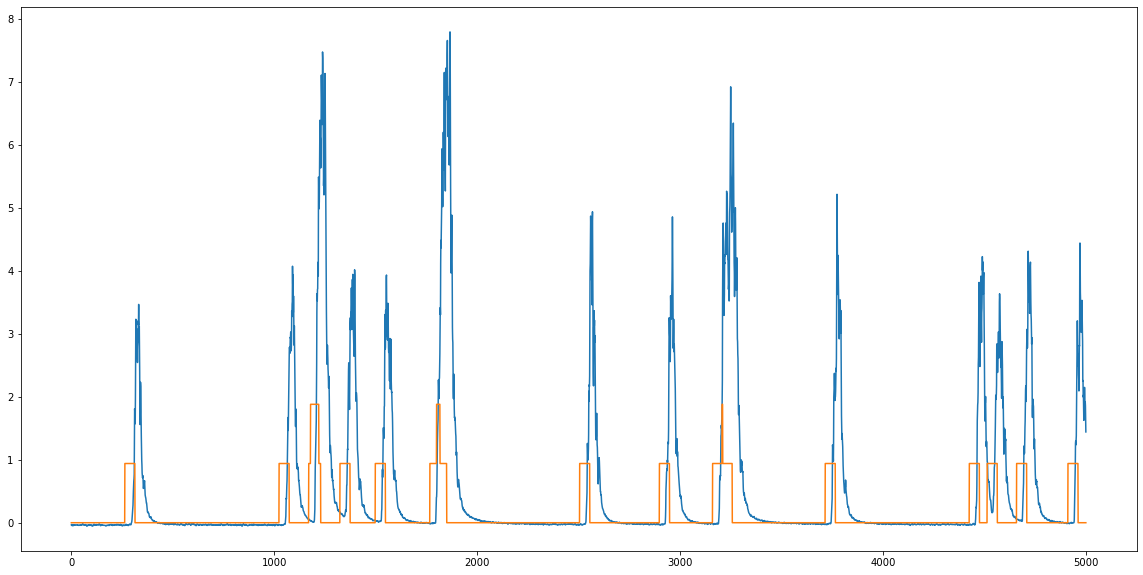

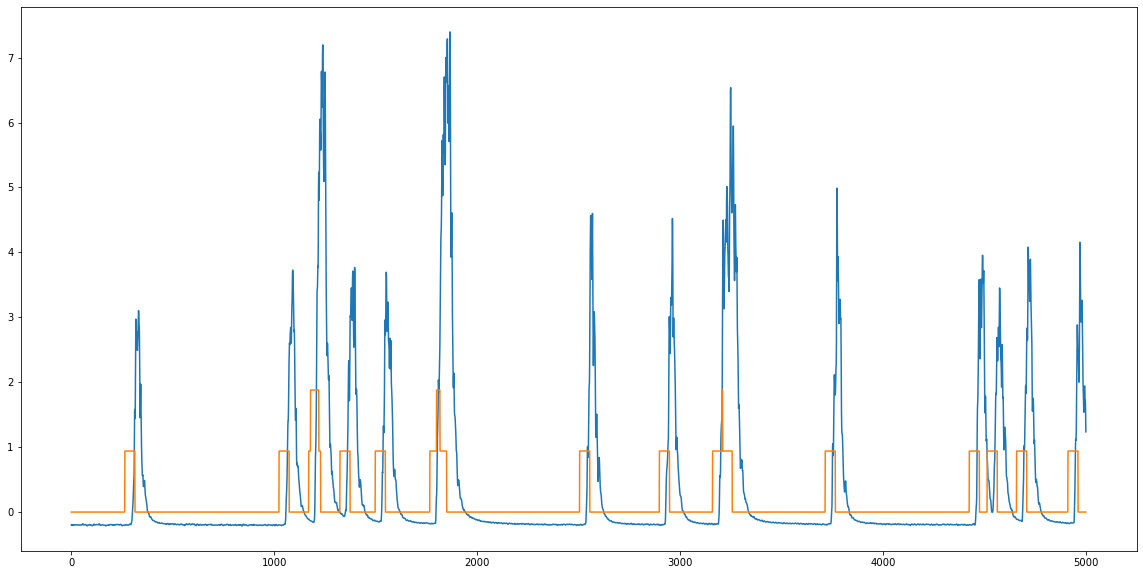

In [79]:
trial=5

plt.figure(figsize=(20,10))

plt.plot(PID[trial,:5000])
plt.plot(trial_odor[trial,:5000]/100)

plt.figure(figsize=(20,10))

plt.plot(PID_filt[trial,:5000])
plt.plot(trial_odor[trial,:5000]/100)

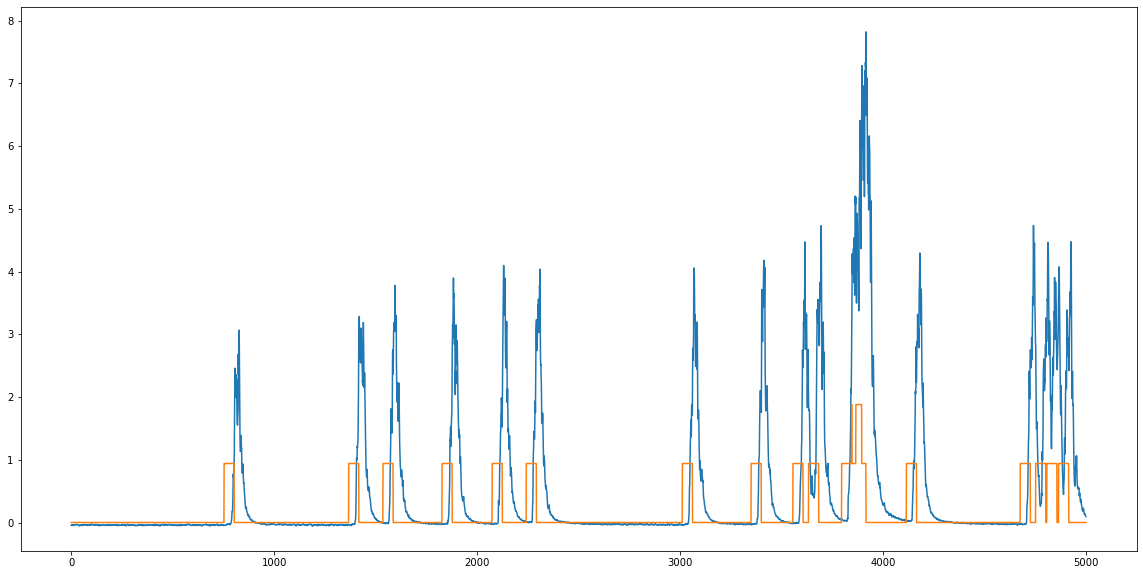

In [145]:
trial=12
plt.figure(figsize=(20,10))

plt.plot(data_test_oh[:5000])
plt.plot(trial_odor[trial,:5000]/100)

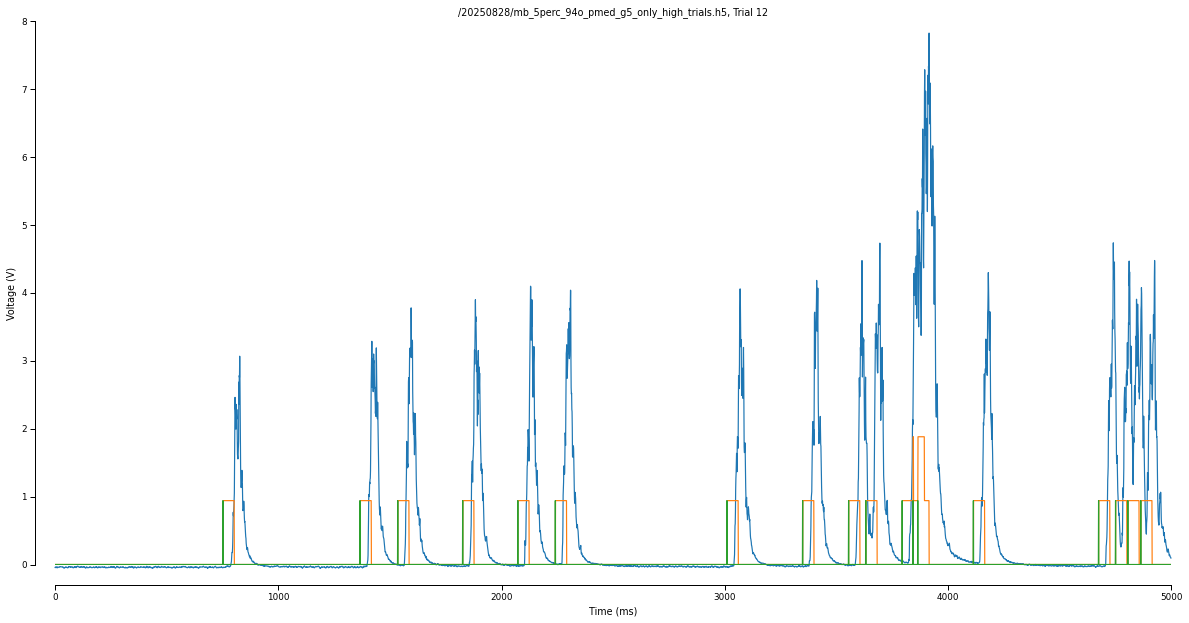

In [329]:
trial=12

plt.figure(figsize=(20,10))

plt.plot(PID[trial,:5000], clip_on=False)
plt.plot(trial_odor[trial,:5000]/100)
plt.plot(np.diff(trial_odor[trial, :5000])/100)
plt.xlim(0,5000)
plt.ylim(0,8)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('/20250828/mb_5perc_94o_pmed_g5_only_high_trials.h5, Trial '+str(trial))
sns.despine(offset=20)

plt.savefig('PID_methyl_butyrate_5perc_high_trial.svg', format='svg', bbox_inches='tight', transparent='true')
plt.savefig('PID_methyl_butyrate_5perc_high_trial.png', format='png', bbox_inches='tight', transparent='true')
plt.savefig('PID_methyl_butyrate_5perc_high_trial.pdf', format='pdf', bbox_inches='tight', transparent='true')

/Users/boero/OEA_Data_Analysis/PID/20250828/ev_5perc_94o_pmed_g5_1.h5
block_training
5000 1500
41


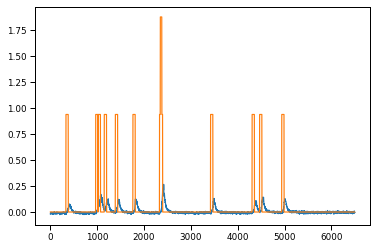

In [335]:
path = os.getcwd() + '/PID/20250828/'
filename = 'ev_5perc_94o_pmed_g5_1.h5'
filepath = path + filename
print(filepath)
dfile = h5py.File(filepath,'r')
print(list(dfile['measurement'].keys())[0]) #['measurement'].keys()
data_ev = dfile['measurement/block_training/buffer'][:] #load data buffer to numpy arrray
stat = dfile['measurement/block_training/stat'][:] #load task statistics
side_stat = dfile['measurement/block_training/side_stat'][:]  #load task statistics with side information
settings = dfile['measurement/block_training/settings'].attrs

# Load raw data into numpy array
lick0 = 1
lick1 = 2
PID_index = 3 # index number for PID signal
cl_air = 6 + 4 #index number of clean air channel in h5file
odor_1 = 6 + 3 #index number of odor channel 1 in h5file
end_time_ev = len(data_ev) # in milisecond
delay_time_ev = settings['delay'] #ms, delay time of the task

go_time_ev = settings['go'] #ms, go time of the task
refract_time_ev = settings['refract'] #ms, refraction period time of the task
pulse_time = 50
ntrials_ev = np.argwhere(np.diff(data_ev[:,cl_air]) == -94).shape[0]
print(delay_time_ev, go_time_ev)
print(ntrials_ev)

PID_signal_ev = data_ev[0:end_time_ev,PID_index]-np.median(data_ev[0:end_time_ev,PID_index])
#filt_signal = pid_functions.bp_filter(PID_signal-np.median(PID_signal))
#odor_profile_1 = data[0:end_time,odor_1]

total_time_ev = delay_time_ev + go_time_ev #ms, the total time that we are analyzing for each trial
onset_ev = np.argwhere(np.diff(data_ev[:,cl_air]) == -94).reshape(ntrials_ev,1) #find out hte onset of each trial
interval_ev = np.arange(total_time_ev).reshape(1,total_time_ev) #define a interval to extract for each trial
refract_interval_ev = np.arange(refract_time)[::-1].reshape(1,refract_time) # define a interval for pretrial, flipped
trial_inds_ev = onset_ev + interval_ev #get the indices for all the wanted data for all trials
pre_inds_ev = onset_ev - refract_interval_ev #get the indices for all the wanted data in all pre-trials

# get all the trial informations
trial_odor_ev = data_ev[:,odor_1][trial_inds_ev[:-1,:]]
PID_ev = PID_signal_ev[trial_inds_ev[:-1,:]]
#PID_filt = filt_signal[trial_inds[:-1,:]]

plt.plot(PID_ev[6,:])
plt.plot(trial_odor_ev[6,:]/100) #The /500 is arbitrary just to have it in the same scale as the PID
#plt.savefig('new_PID_trace.svg', format='svg', transparent='True')


0 17.0


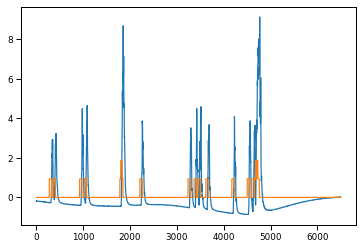

1 0.0


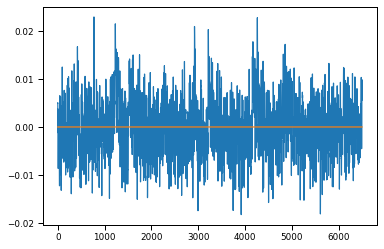

2 13.0


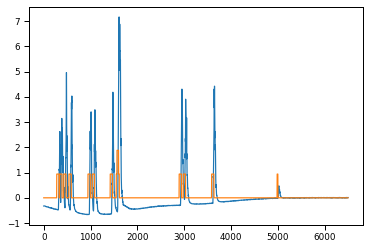

3 12.0


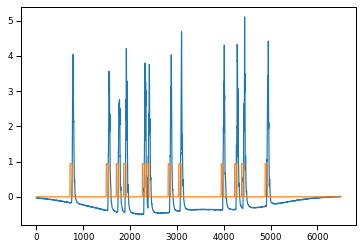

4 12.0


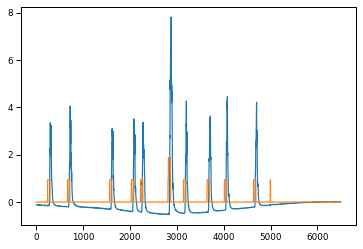

5 17.0


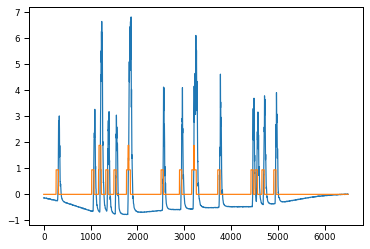

6 17.0


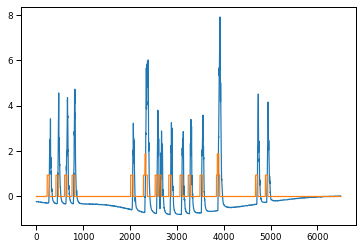

7 0.0


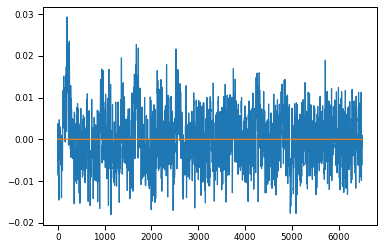

8 10.0


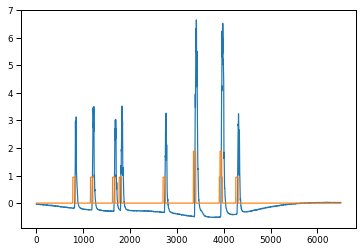

9 23.0


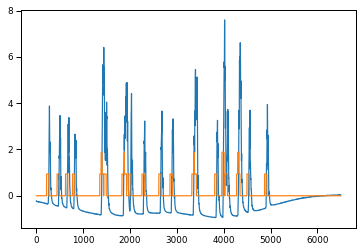

10 11.0


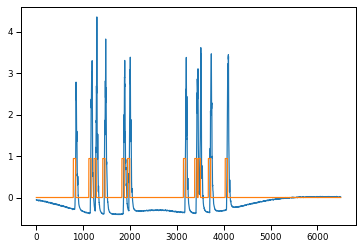

11 9.0


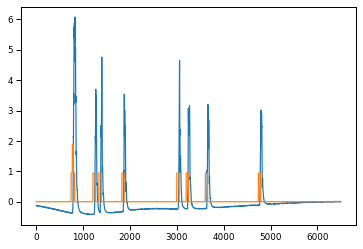

12 18.0


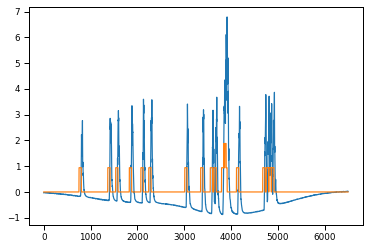

13 12.0


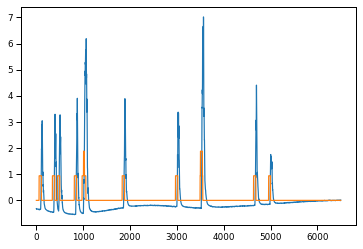

14 13.0


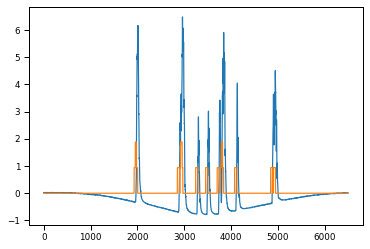

15 10.0


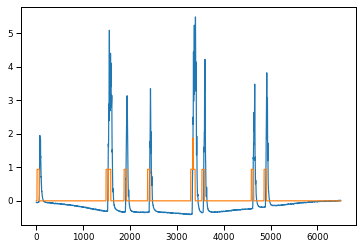

16 15.0


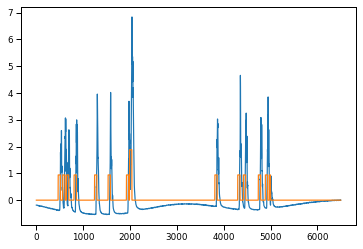

17 10.0


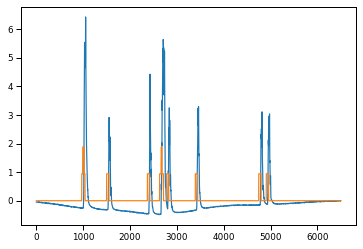

18 12.0


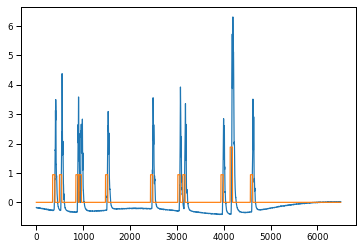

19 13.0


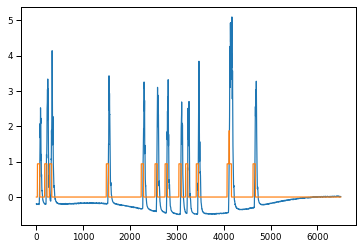

20 0.0


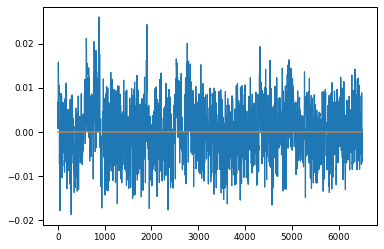

21 15.0


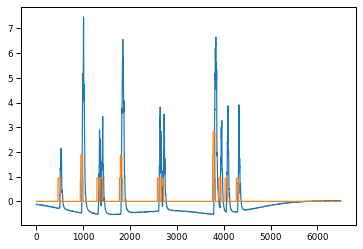

22 13.0


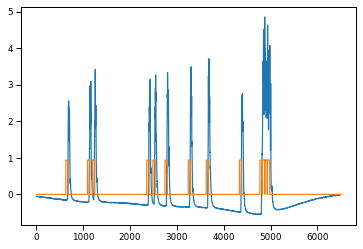

23 12.0


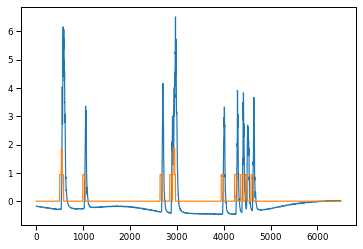

24 12.0


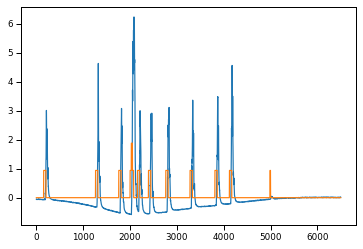

25 15.0


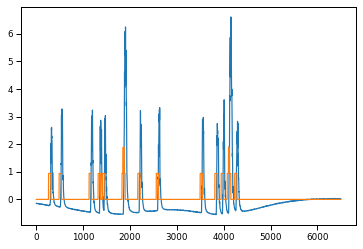

26 12.0


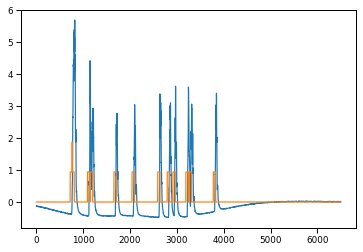

27 16.0


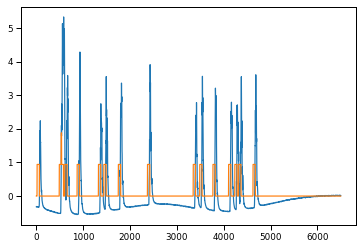

In [336]:
for i in range(len(trial_inds[:-1])):
    print(i, np.ceil(trial_odor[i,:].sum()/(50*94)))
    plt.plot(PID_filt[i,:])
    plt.plot(trial_odor[i,:]/100)
    plt.show() #The /500 is arbitrary just to have it in the same scale as the PID

0 1.0


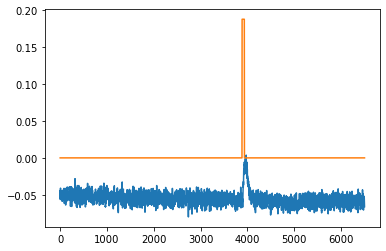

1 4.0


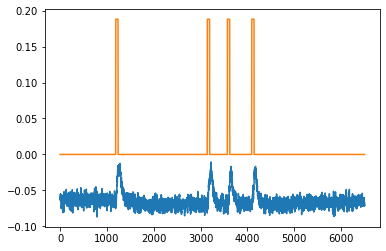

2 3.0


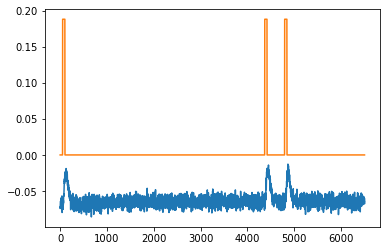

3 4.0


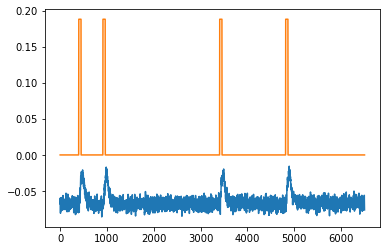

4 5.0


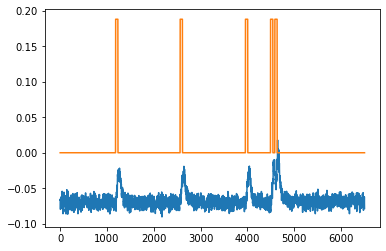

5 12.0


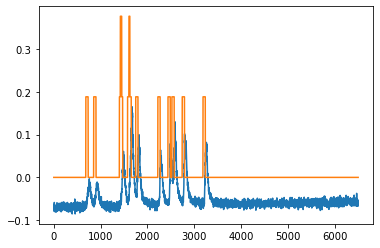

6 12.0


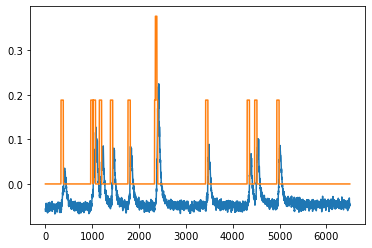

7 18.0


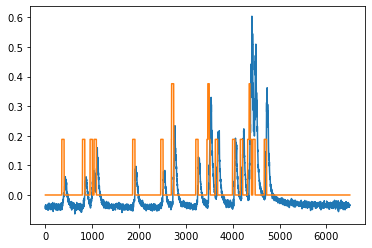

8 12.0


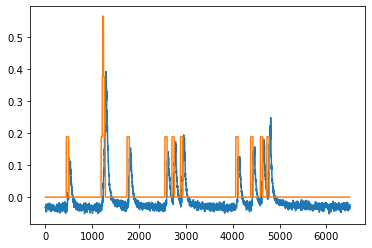

9 12.0


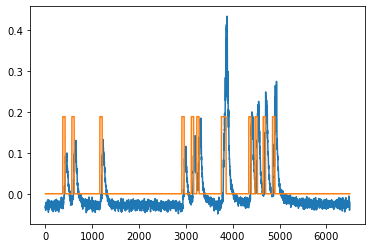

10 2.0


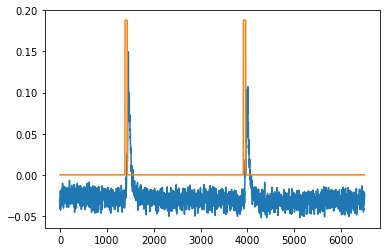

11 2.0


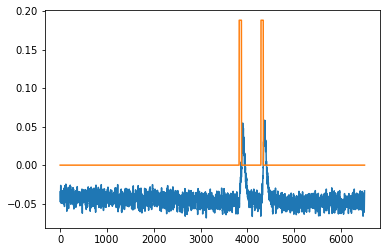

12 2.0


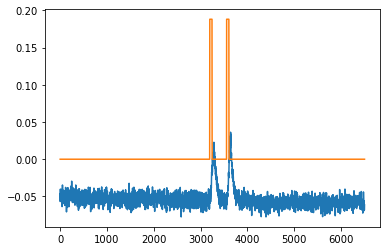

13 3.0


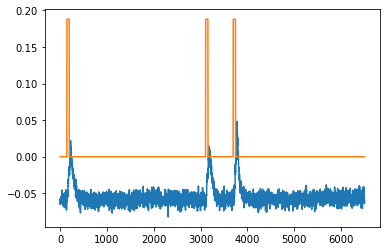

14 1.0


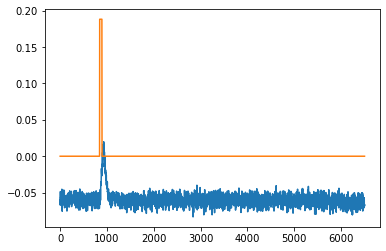

15 17.0


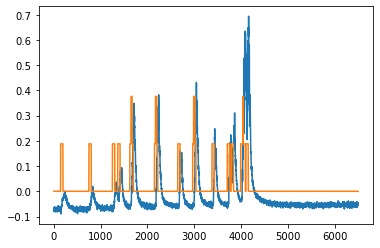

16 14.0


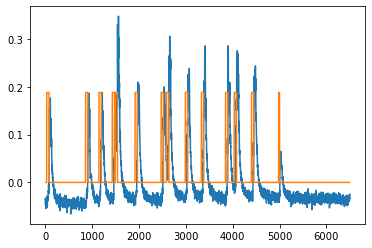

17 10.0


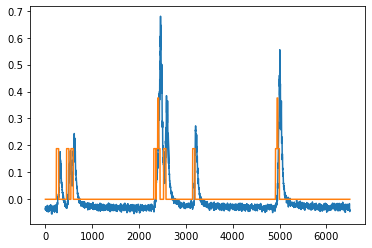

18 9.0


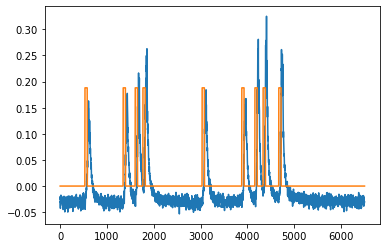

19 13.0


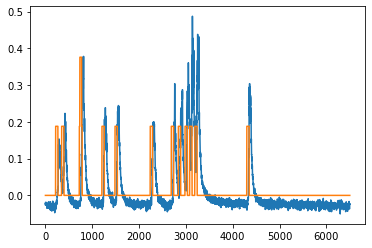

20 8.0


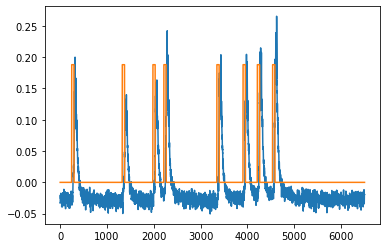

21 3.0


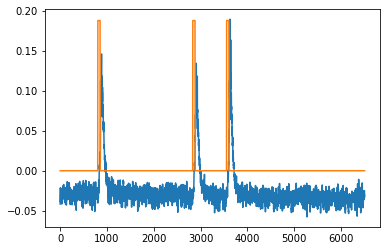

22 5.0


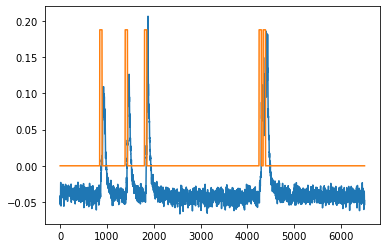

23 4.0


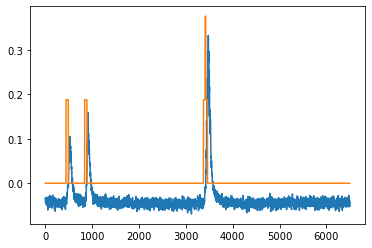

24 2.0


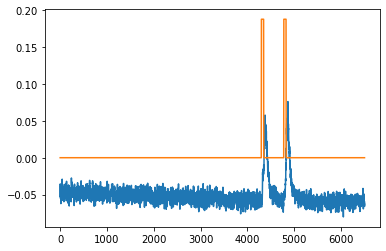

25 15.0


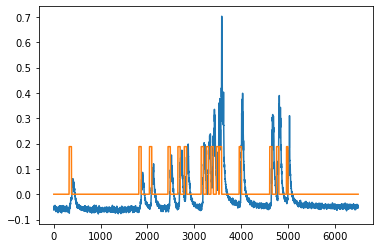

26 10.0


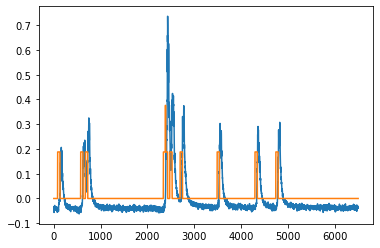

27 14.0


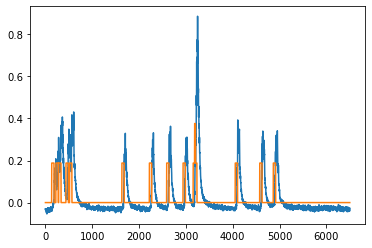

28 19.0


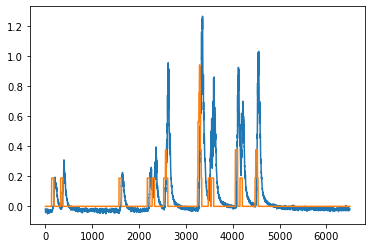

29 13.0


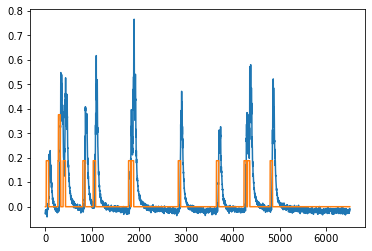

30 2.0


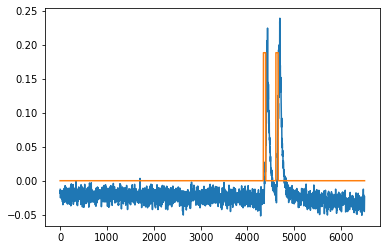

31 3.0


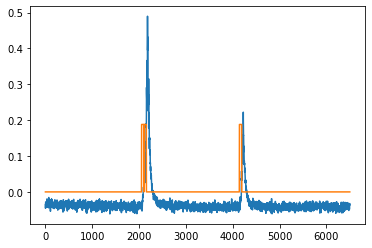

32 2.0


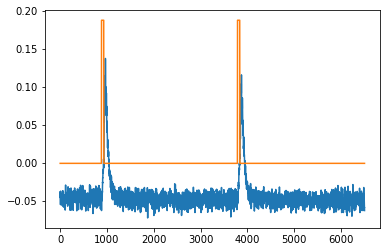

33 0.0


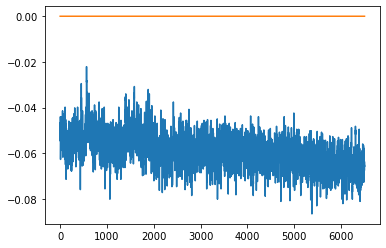

34 3.0


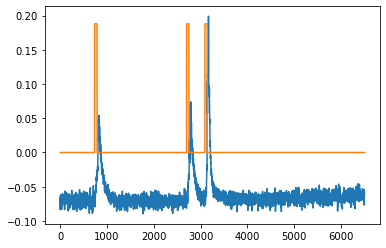

35 9.0


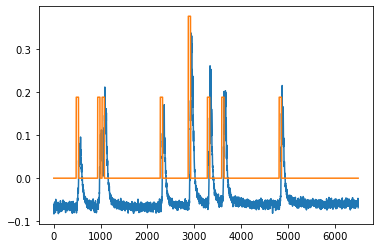

36 13.0


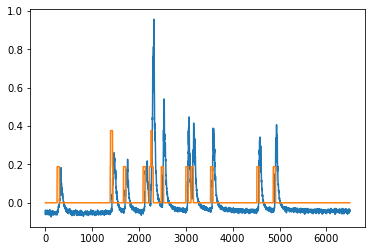

37 0.0


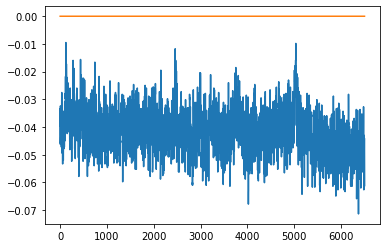

38 16.0


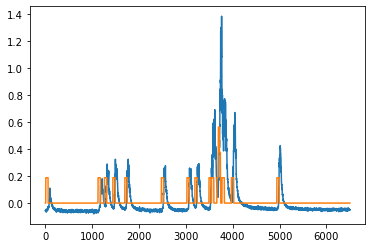

39 12.0


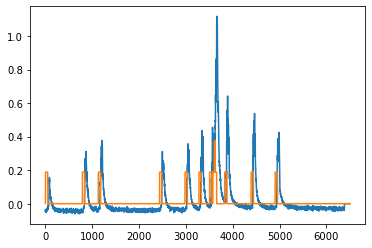

In [222]:
for i in range(len(trial_inds_ev[:-1])):
    print(i, np.ceil(trial_odor_ev[i,:].sum()/(50*94)))
    plt.plot(PID_ev[i,:])
    plt.plot(trial_odor_ev[i,:]/500)
    plt.show()

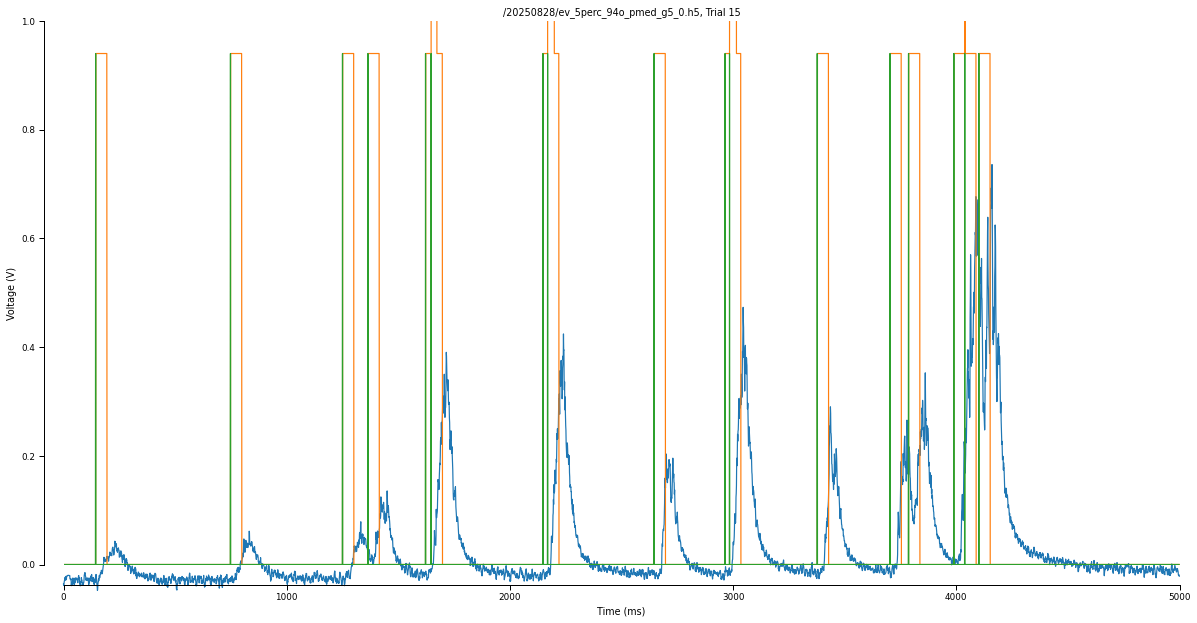

In [340]:
trial=15

plt.figure(figsize=(20,10))

plt.plot(PID_ev[trial,:5000], clip_on=False)
plt.plot(trial_odor_ev[trial,:5000]/100)
plt.plot(np.diff(trial_odor_ev[trial, :5000])/100)
plt.xlim(0,5000)
plt.ylim(0,1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('/20250828/ev_5perc_94o_pmed_g5_0.h5, Trial '+str(trial))
sns.despine(offset=20)

plt.savefig('PID_ethyl_valerate_5perc_high_trial.svg', format='svg', bbox_inches='tight', transparent='true')
plt.savefig('PID_ethyl_valerate_5perc_high_trial.png', format='png', bbox_inches='tight', transparent='true')
plt.savefig('PID_ethyl_valerate_5perc_high_trial.pdf', format='pdf', bbox_inches='tight', transparent='true')

In [223]:
lowtrials_ev = np.concatenate([np.arange(start, start+5) for start in range(0, 35, 10)])
print(lowtrials_ev)


[ 0  1  2  3  4 10 11 12 13 14 20 21 22 23 24 30 31 32 33 34]


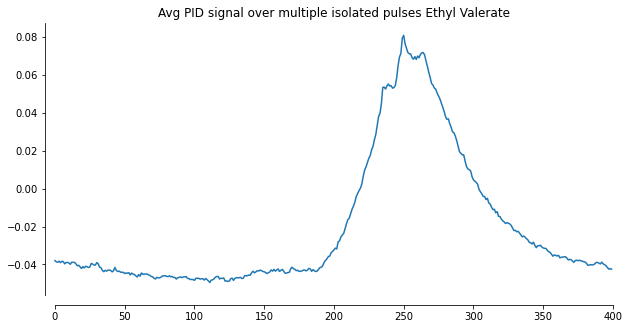

In [228]:
snips_ev =  list()
to_low_ev = trial_odor_ev[lowtrials_ev,:] #[lowtrials_ev,:]
pid_low_ev = PID_ev[lowtrials_ev,:]
for i in range(to_low_ev.shape[0]):
    _, all_snippets, _ = average_peak_triggered(to_low_ev[i,:], pid_low_ev[i,:], fs=1000, pre_ms=200, post_ms=200, min_interval_ms=600, height=[10,95], prominence=1)
    snips_ev.append(all_snippets)

cleaned_ev = [x for x in snips_ev if len(x) > 0]
flattened_ev = list(chain.from_iterable(cleaned_ev))
f_array_ev = np.array(flattened_ev)

plt.figure(figsize=(10,5))
plt.plot(f_array_ev.mean(0), clip_on=False)
plt.title('Avg PID signal over multiple isolated pulses Ethyl Valerate')
plt.xlim(0,400)
#plt.ylim(0,3)
sns.despine(offset=10)